In [5]:
import quandl
import pandas as pd
import pytz
from collections import OrderedDict

quandl.ApiConfig.api_key = "uRMo697HgMj91ZZZa2_v"
data = OrderedDict()
data['AAPL'] = quandl.get('EOD/AAPL',start_date='2009-01-01', end_date='2020-01-03')
data['AAPL'] = data['AAPL'][['Open','High','Low','Close','Volume']]
data['AAPL'] = data['AAPL'].rename(columns={"Open": "open", "High": "high",'Close':"close","Low":"low","Volume":"volume"})
panel = pd.Panel(data)
panel.minor_axis = ["open","high","low","close","volume"]
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 1 (items) x 2770 (major_axis) x 5 (minor_axis)
Items axis: AAPL to AAPL
Major_axis axis: 2009-01-02 00:00:00+00:00 to 2020-01-03 00:00:00+00:00
Minor_axis axis: open to volume


In [9]:
from zipline.api import order_target_percent, record, symbol,get_datetime,set_benchmark,order,order_percent,get_open_orders
from zipline.finance import commission
from zipline import run_algorithm
import matplotlib.pyplot as plt
import numpy as np
import pytz
import pandas as pd
import datetime
import pickle


# parameters 
ma_periods = 3
selected_stock = 'AAPL'
#with open('Apple_model.pickle','rb') as f:
    #Apple.pickle = pickle.load(f)

def initialize(context):
    context.time = 0
    context.asset = symbol(selected_stock)
    set_benchmark(symbol('AAPL'))
    # 1. manually setting the commission
    context.set_commission(commission.PerShare(cost=0.001, min_trade_cost=0))
    
def handle_data(context, data):
    # 2. warm-up period
    context.time += 1
    #if context.time < ma_periods:
        #return
    # 3. access price history
    price_history = data.history(context.asset, fields="price", bar_count=ma_periods, frequency="1d")
    return1 = price_history[1]/price_history[0]- 1
    pred = pd.read_csv("test2.csv")
    pred["pred return"] =  pred["adj_close"]/pred["adj_close"].shift(1) - 1
    pred["pred return"] = pred["pred return"].fillna(0)
    pred["Date"] = pd.to_datetime(pred["Date"])   
    # 4. calculate moving averages
    #ma2 = price_history.mean()
    tday=get_datetime().date()
    pr1 = pred[pred["Date"]==tday]["pred return"].values
    ma1 =pred[pred["Date"]==tday]["adj_close"].values
    p = context.portfolio.positions[0].amount
    ma = ma1[0]
    pr = pr1[0]
    #except:
        #ma = price_history.mean()
        #date= tday-datetime.timedelta(days=1)
        #if date == '2017-08-07':
            #pr = pred[pred["date"]=='2017-08-05']["pred return"].values
        #else:
            #pr = pred[pred["date"]=='2017-11-07']["pred return"].values
        #pr=pr[0]
    # 5. trading logic
    if(return1*pr)<=0:
        if pr == 0:
            order_target_percent(context.asset, 1)
        if return1 <0 and pr>0:
            order_target_percent(context.asset, 0.5)
        elif return1 > 0 and pr<0:
            order_target_percent(context.asset, 1)
    else:
        if pr == 0:
            order_target_percent(context.asset, 1)
        elif pr>0:
            number_stock = round(pr*p)
            order(context.asset, 2*number_stock)
        elif pr<0:
            number_stock = round(pr*p)
            order(context.asset, number_stock)
    # save values for later inspection
    record(price=data.current(context.asset, 'price'),
           predict_price=ma,predict_returns=pr,returns =return1,leverage=context.account.leverage)
# 6. analyze block
def analyze(context, perf):
    fig, ax = plt.subplots(4, 1, sharex=True, figsize=[10,10])
    # portfolio value
    perf[['price', 'predict_price']].plot(ax=ax[0])
    ax[0].set_ylabel('portfolio value in $')
    
    # asset
    perf[['price', 'predict_price']].plot(ax=ax[1])
    ax[1].set_ylabel('price in $')
    
    # mark transactions
    perf_trans = perf.loc[[t != [] for t in perf.transactions]]
    buys = perf_trans.loc[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
    sells = perf_trans.loc[[t[0]['amount'] < 0 for t in perf_trans.transactions]]
    ax[1].plot(buys.index, perf.price.loc[buys.index], '^', markersize=10, color='g', label='buy')
    ax[1].plot(sells.index, perf.price.loc[sells.index], 'v', markersize=10, color='r', label='sell')
    ax[1].legend()
    
    # daily returns
    perf.algorithm_period_return.plot(ax=ax[2])
    perf.benchmark_period_return.plot(ax=ax[2])
    ax[2].set_ylabel('daily returns')
    ax[2].legend()
    
    perf.leverage.plot(ax=ax[3])
    ax[3].set_ylabel('leverage')
    ax[3].legend()
    
    fig.suptitle('Simple LSTM Strategy - Apple', fontsize=16)
    plt.legend()
    plt.show()
    
    print('Final portfolio value (including cash): {}$'.format(np.round(perf.portfolio_value[-1], 2)))
    print(perf.tail())

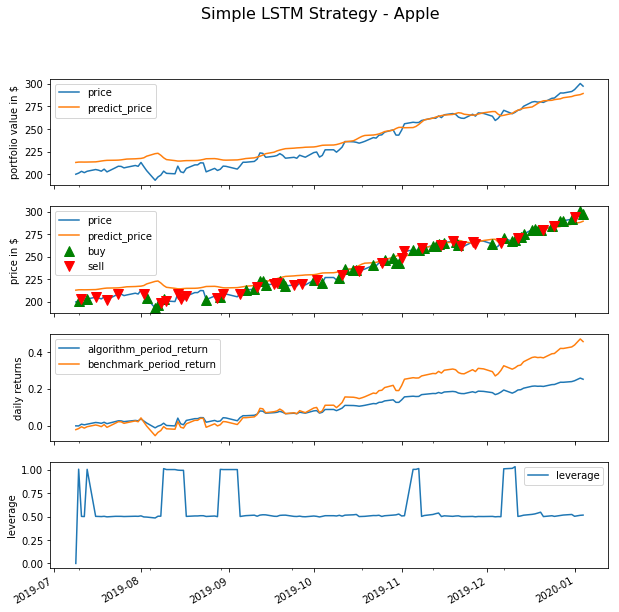

Final portfolio value (including cash): 125244.26$
                           algo_volatility  algorithm_period_return     alpha  \
2019-12-27 21:00:00+00:00         0.142462                 0.235959  0.011816   
2019-12-30 21:00:00+00:00         0.141889                 0.239740  0.010947   
2019-12-31 21:00:00+00:00         0.141340                 0.244456  0.010008   
2020-01-02 21:00:00+00:00         0.141436                 0.258724  0.007401   
2020-01-03 21:00:00+00:00         0.141204                 0.252443  0.008886   

                           benchmark_period_return  benchmark_volatility  \
2019-12-27 21:00:00+00:00                 0.418988              0.230595   
2019-12-30 21:00:00+00:00                 0.427410              0.229687   
2019-12-31 21:00:00+00:00                 0.437840              0.228833   
2020-01-02 21:00:00+00:00                 0.470646              0.229633   
2020-01-03 21:00:00+00:00                 0.456348              0.229441   

     

In [10]:
from zipline.api import order, record, symbol, set_benchmark
import zipline
import matplotlib.pyplot as plt
from datetime import datetime

perf = zipline.run_algorithm(start=datetime(2019, 7, 8, 0, 0, 0, 0, pytz.utc),
                      end=datetime(2020, 1, 3, 0, 0, 0, 0, pytz.utc),
                      initialize=initialize,
                      capital_base=100000,
                      handle_data=handle_data,
                      analyze = analyze,
                      data=panel)